In [125]:
#imports personal details to connect to db
import config
#import our function files
import query_helper
import payscale_uni_webscrape


import json
import requests
from bs4 import BeautifulSoup
api_key = config.API_key
import time 
import mysql.connector
from mysql.connector import errorcode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics
import math
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.power import TTestIndPower

# Below 2 cells creates database

In [126]:
# db_name = 'colleges'
# ## Connect to DB server on AWS
# ## connecting to the database using 'connect()' method
# ## it takes 3 required parameters 'host', 'user', 'passwd'
# cnx = mysql.connector.connect(
#     host = config.host,
#     user = config.user,
#     passwd = config.password,
#     database = "colleges"       #can say what database we expect everything loaded into
# )
# cursor = cnx.cursor()

In [127]:
# def create_database(cursor, database):
#     try:
#         cursor.execute(
#             "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
#     except mysql.connector.Error as err:
#         print("Failed creating database: {}".format(err))
#         exit(1)

# try:
#     cursor.execute("USE {}".format(db_name))
# except mysql.connector.Error as err:
#     print("Database {} does not exists.".format(db_name))
#     if err.errno == errorcode.ER_BAD_DB_ERROR:
#         create_database(cursor, db_name)
#         print("Database {} created successfully.".format(db_name))
#         cnx.database = db_name
#     else:
#         print(err)
#         exit(1)

In [ ]:
db_name = 'colleges'
## Connect to DB server on AWS
## connecting to the database using 'connect()' method
## it takes 3 required parameters 'host', 'user', 'passwd'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = "colleges"       #can say what database we expect everything loaded into
)
cursor = cnx.cursor()

In [ ]:
def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

In [ ]:
#write a query entry to creat a table
payscale_colleges = """
CREATE TABLE payscale_colleges (
      uni varchar(100) PRIMARY KEY,
      uni_type varchar(100),
      early_car_pay int,
      mid_car_pay int,
      high_meaning float,
      stem_deg float
    );
"""

In [ ]:
query_helper.create_table(payscale_colleges)

In [3]:
#Below code gets info for page then commits to db, repeats process on all pages
#if we have duplicates they will be skipped on db commit process

web_page_iterator = 1
while web_page_iterator <64:
    #scrape web infor for 1 page
    list_of_dict = payscale_uni_webscrape.get_pages(web_page_iterator)

    #put infor into tuples and commit to db
    query_helper.tuple_payscale_uni(list_of_dict)
    
    #iterate and loop
    web_page_iterator +=1
    


KeyboardInterrupt: 

In [4]:
df = query_helper.query_to_df('SELECT * FROM payscale_colleges')

In [19]:
# df[df['early_car_pay']]
df_private = df[df.uni_type.str.contains('Private')==True]

In [34]:
df['Private'] = 0
df.head()
df["uni_type"][0]

'Private School, Religious, For Sports Fans'

In [36]:
"Private" in df['uni_type'][0]

True

In [35]:
df.head()

,uni,uni_type,early_car_pay,mid_car_pay,high_meaning,stem_deg,Private
0,Abilene Christian University,"Private School, Religious, For Sports Fans",49700,90900,53.0,9.0,0
1,Adams State University,State School,44400,81400,56.0,3.0,0
2,Adelphi University,"Private School, Research University",53700,96400,50.0,6.0,0
3,Adrian College,"Private School, Religious",42400,78000,58.0,12.0,0
4,Adventist University of Health Sciences,"Private School, Religious",51600,89800,88.0,5.0,0


In [40]:
df['uni_type'].dtypes

dtype('O')

In [99]:
df["Private"] = df.uni_type.apply(lambda x: 1 if "Private" in x else 0)

In [102]:
df.head()

,uni,uni_type,early_car_pay,mid_car_pay,high_meaning,stem_deg,Private
0,Abilene Christian University,"Private School, Religious, For Sports Fans",49700,90900,53.0,9.0,1
1,Adams State University,State School,44400,81400,56.0,3.0,0
2,Adelphi University,"Private School, Research University",53700,96400,50.0,6.0,1
3,Adrian College,"Private School, Religious",42400,78000,58.0,12.0,1
4,Adventist University of Health Sciences,"Private School, Religious",51600,89800,88.0,5.0,1


In [112]:
df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()

                      Private
early_car_pay  count  0            580.000000
                      1            985.000000
               mean   0          49548.275862
                      1          48995.329949
               std    0           6900.890818
                      1           8315.776130
mid_car_pay    count  0            580.000000
                      1            985.000000
               mean   0          89155.344828
                      1          88395.837563
               std    0          13135.943480
                      1          15714.752563
dtype: float64

In [115]:
df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[0]

580.0

In [118]:
public_early_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[0]
private_early_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[1]
public_early_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[2]
private_early_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[3]
public_early_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[4]
private_early_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[5]

# get mid career info
public_mid_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[6]
private_mid_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[7]
public_mid_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[8]
private_mid_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[9]
public_mid_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[10]
private_mid_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[11]


In [119]:
print(public_early_count)
print(private_early_count)
print(public_early_mean)
print(private_early_mean)
print(public_early_std)
print(private_early_std)

print(public_mid_count)
print(private_mid_count) 
print(public_mid_mean)
print(private_mid_mean)
print(public_mid_std)
print(private_mid_std)

580.0
985.0
49548.275862068964
48995.32994923858
6900.890818301473
8315.776129743184
580.0
985.0
89155.3448275862
88395.83756345177
13135.94347990051
15714.75256259765


In [54]:
df_private = df[df['Private']==1]
df_public = df[df["Private"]==0]

In [86]:
private=df_private['early_car_pay']
private_list = private.tolist()
private.describe()

public=df_public['early_car_pay']
public_list = public.tolist()
public.describe()

count      580.000000
mean     49548.275862
std       6900.890818
min      32500.000000
25%      44775.000000
50%      48650.000000
75%      52700.000000
max      80600.000000
Name: early_car_pay, dtype: float64

In [93]:
# mu_private = private.mean()
# sigma_private = private.std()

# mu_private, sigma_private

(48995.32994923858, 8315.776129743188)

In [ ]:
# ambient_pressure = df['AP'].values
# standardized_ambient_pressure = (ambient_pressure - mu)/sigma

[]

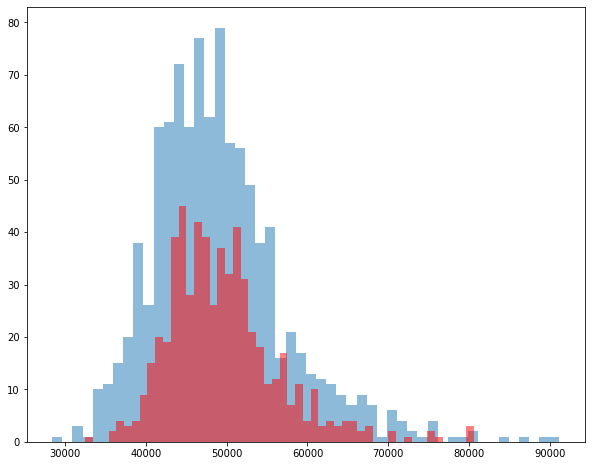

In [94]:
plt.figure(figsize=(10,8))
plt.hist(private_list, bins=50, alpha=.5)
plt.hist(public_list, bins=50, color='r', alpha = 0.5)
plt.plot()

## One-sample z-tests!

Recall the test statistic for a one-sample z-test is the z-statistic: 

$$ \large \text{z-statistic} = \dfrac{\bar x - \mu_0}{{\sigma}/{\sqrt{n}}} $$

* $\bar x$ is your sample mean
* $n$ is the number of items in your sample 
* $\sigma$ is the population standard deviation
* $\mu_0$ is the population mean

The z-statistic differs from the standard score formula: we divide the standard deviation by the square root of $n$ to reflect that we are dealing with the _sample variance_. 

## Now well do a 2 sample z test


In [122]:
standard_error_of_mean_diff = math.sqrt((public_early_std**2/public_early_count +private_early_std**2/private_early_count))
z = (public_early_mean-private_early_mean)/(standard_error_of_mean_diff)
z

1.4168201211290246

We fail to reject out null hypothesis

There is no significant difference in early career expected salary for those who attend public vs private school 

I could have made a type 2 error

## Now well do power analysis

In [132]:
p_value = stats.norm.sf(abs(z)) #one-sided
p_value

0.07826776266232675

In [133]:
beta = 1-p_value
beta

0.9217322373376733

It appears there is and 8% chance we made a Type 2 error


In [137]:
# # solve for power
# power_analysis = TTestIndPower()
# # calculate the power
# power = power_analysis.solve_power(effect_size=0.5, nobs1=500, alpha=.05)
# print("power is" + " " + str(power))
# #Calculate sample size required
# sample_size = power_analysis.solve_power(effect_size=.2, alpha=.05, power=.8)
# print("number of observation required is" + " "+ str(sample_size))

## Sample using Central limit theorem to get normal distribution

Mean: 48992.65063, Standard Deviation: 789.4061259520369
Mean: 49547.92285, Standard Deviation: 628.4270467268874


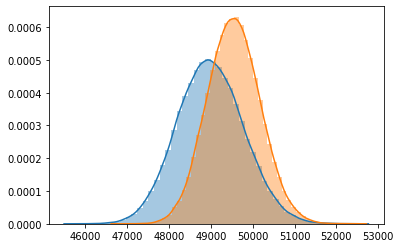

In [90]:
samples = [np.random.choice(private_list, replace=False, size=100) for i in range(100000)]
print('Mean: {}, Standard Deviation: {}'.format(
                                                np.mean([np.mean(i) for i in samples]),
                                                np.std([np.mean(i) for i in samples])
                                            )
     )

samples1 = [np.random.choice(public_list, replace=False, size=100) for i in range(100000)]
print('Mean: {}, Standard Deviation: {}'.format(
                                                np.mean([np.mean(i) for i in samples1]),
                                                np.std([np.mean(i) for i in samples1])
                                            )
     )
sns.distplot([np.mean(i) for i in samples])
sns.distplot([np.mean(i) for i in samples1])
